In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import seaborn as sns
from matplotlib import rcParams

In [ ]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

dpi = 200

pretty_palette = ["#C85158",
                    "#62A48F",
                    "#475A7A",
                    "#503A38",
                    "#E9AD97",
                    "#88A4BA",][::-1]

In [3]:
gaussian_df = pd.read_csv('https://raw.githubusercontent.com/ggdna/scScaling/main/results/Caltech101_Gaussian.csv')
res_df = pd.read_csv('https://raw.githubusercontent.com/ggdna/scScaling/main/results/Caltech101_resolution.csv')
classes = sorted(gaussian_df[gaussian_df['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']
gaussian_df['Scale'] = gaussian_df['Scale']**2
res_df['Factor'] = res_df['Factor']

def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/collect_mi_results.csv')
df.replace('celltype.l3', 'Cell type MI', inplace=True)
df.replace('protein_counts', 'Protein MI', inplace=True)
df.replace('clone', 'Clonal MI', inplace=True)
df.replace('author_day', 'Developmental MI', inplace=True)
df.replace('ng_idx', 'Spatial MI', inplace=True)
df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [5]:
sc_param_df = pd.read_csv('analysis/final_results/scaling_plots_u_bar_138.109_I_max_1.419.csv')
sc_param_df.replace('celltype.l3', 'Cell type MI', inplace=True)
sc_param_df.replace('protein_counts', 'Protein MI', inplace=True)
sc_param_df.replace('clone', 'Clonal MI', inplace=True)
sc_param_df.replace('author_day', 'Developmental MI', inplace=True)
sc_param_df.replace('ng_idx', 'Spatial MI', inplace=True)
sc_param_df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

sc_param_df

,dataset,method,metric,size,fitted_u_bar,fitted_I_max,u_bar_error,I_max_error
0,shendure,Geneformer,Developmental MI,100,116.021,0.802,24.386,0.036
1,shendure,Geneformer,Developmental MI,359,207.217,1.243,20.798,0.026
2,shendure,Geneformer,Developmental MI,1291,271.351,1.504,44.861,0.051
3,shendure,Geneformer,Developmental MI,4641,403.606,1.794,42.211,0.038
4,shendure,Geneformer,Developmental MI,16681,342.730,1.938,18.838,0.020
...,...,...,...,...,...,...,...,...
195,PBMC,SCVI,Protein MI,4641,1366.756,3.896,294.280,0.109
196,PBMC,SCVI,Protein MI,10000,3339.672,4.588,419.178,0.072
197,PBMC,SCVI,Protein MI,21544,6967.881,5.162,814.322,0.074
198,PBMC,SCVI,Protein MI,46415,5215.633,5.106,569.952,0.067


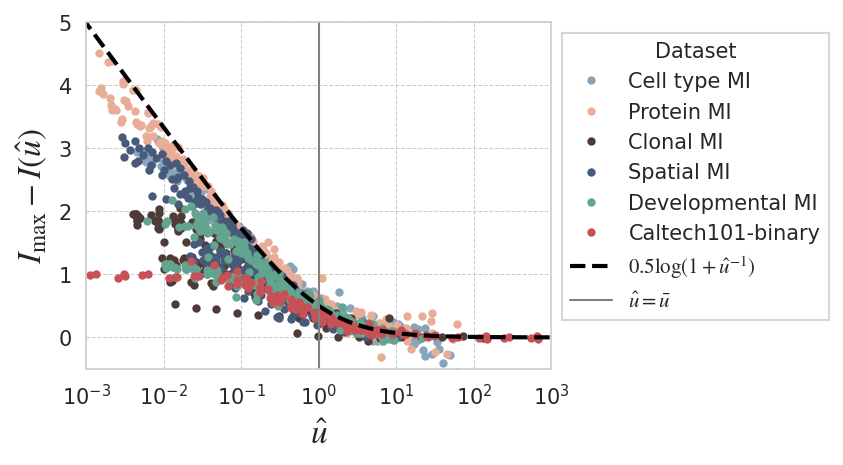

In [6]:
def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

# plotting setup
fig, ax = plt.subplots()

# params
lw, alpha, ms = 0, 1, 3
hue_order = ['PCA', 'SCVI', 'Geneformer']
plot_fits = False
signals = df['signal'].unique().tolist()

# iterate over signals
def fit_and_plot(df):
    for idx, sig in enumerate(signals):
        sub = df[df['signal'] == sig]
        for s in sub['size'].unique():
            part = sub[sub['size'] == s]
            for alg in hue_order:
                dat = part[part['algorithm'] == alg]
                dat = dat.groupby('umis_per_cell')[['umis_per_cell', 'mi_value']].mean()
                x = dat['umis_per_cell']
                y = dat['mi_value']

                if len(y) < 10:
                    continue

                # get params from sc_param_df
                row = sc_param_df[(sc_param_df['metric'] == sig) 
                                  & (sc_param_df['method'] == alg)
                                  & (sc_param_df['size'] == s)]
                if row.empty:
                    continue
                xbar = row['fitted_u_bar'].values[0]
                imax = row['fitted_I_max'].values[0]
                err_xbar = row['u_bar_error'].values[0]
                err_imax = row['I_max_error'].values[0]

                # check error
                if err_xbar and err_imax and err_xbar < xbar and err_imax < imax:
                    xhat = x / xbar
                    ax.plot(
                        xhat,
                        imax - y,
                        color=pretty_palette[idx],
                        marker='o',
                        alpha=alpha,
                        markersize=ms,
                        label=sig,
                        lw=lw
                    )

                    # plot fit
                    xs = np.logspace(-4, 3.5, 100)
                    A = 1/xbar
                    B = A*(2**(2*imax))
                    ys = info_scaling(xs, A, B)
                    if plot_fits:
                        ax.plot(xs/xbar, imax - ys, color=pretty_palette[idx], linestyle='--',
                            alpha=0.5, lw=0.5, zorder=0.5, )

fit_and_plot(df)


for im_idx, imdf in enumerate([gaussian_df, res_df]):

    for i, x in enumerate(classes[:-1]):
        # prepare data
        x_name = ['Scale', 'Factor'][im_idx]
        x_data = (1 / (imdf[imdf['Class label'] == x][x_name]))
        y_data = imdf[imdf['Class label'] == x]['MI']

        # create model and parameters
        model = Model(info_scaling)
        params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
        params['A'].min = 0  # set bounds
        params['B'].min = 0

        # fit model
        result = model.fit(y_data, params, x=x_data)
        if result.params['A'].stderr is not None and result.params['B'].stderr is not None:

            if result.params['A'].stderr < result.params['A'].value and result.params['B'].stderr < result.params['B'].value:
                

                x_bar = 1/result.params['A'].value

                x_hat = x_data / x_bar

                I_max = 0.5 * np.log2(result.params['B'].value/result.params['A'].value)

                ax.plot(x_data / x_bar, I_max-y_data, color=pretty_palette[-1], marker='o',
                        alpha=alpha, markersize=ms, label='Caltech101-binary', lw=lw)

                # plot fit
                xs = np.logspace(-4, 3.5, 100)
                A = 1/x_bar
                B = A*(2**(2*I_max))
                ys = info_scaling(xs, A, B)
                if plot_fits:
                    ax.plot(xs/x_bar, I_max - ys, color=pretty_palette[-1], linestyle='--',
                        alpha=0.5, lw=0.5, zorder=2, )



xs = np.logspace(-4, 3.5, 100)
ys = 0.5*np.log2(1 + 1/xs)
ax.plot(xs, ys, color='black', linestyle='--', alpha=1, lw=2,
         label=r'$0.5 \log (1 + \hat{u}^{-1})$')
ax.plot([1, 1], [-1, 5.5], color='grey', linestyle='-', alpha=1, label=r'$\hat{u} = \bar{u}$', lw=1)


ax.set_xscale('log')
ax.set_ylabel(r'$I_{\max} - I(\hat{u})$',fontsize=16)
ax.set_xlabel(r'$\hat{u}$', fontsize=16)
ax.set_ylim(-0.5, 5)
ax.set_xlim(1e-3, 1e3)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1., 1.), title='Dataset')
plt.show()

Unconstrained fit for Clonal MI, Geneformer, size 215: err_xbar=17168.51, err_imax=0.675, xbar=12120.065, imax=1.035
Unconstrained fit for Spatial MI, PCA, size 843: err_xbar=110633.637, err_imax=3.358, xbar=23542.467, imax=4.543
Unconstrained fit for Spatial MI, SCVI, size 843: err_xbar=148034677736.325, err_imax=2513.196, xbar=42942291.943, imax=9.594
Unconstrained fit for Spatial MI, PCA, size 1716: err_xbar=10135.34, err_imax=1.096, xbar=6450.315, imax=3.658
Unconstrained fit for Spatial MI, SCVI, size 1716: err_xbar=89653766209.633, err_imax=5703.892, xbar=11337600.791, imax=8.858
Unconstrained fit for Spatial MI, PCA, size 3494: err_xbar=10744.336, err_imax=1.069, xbar=7033.41, imax=3.737
Unconstrained fit for Spatial MI, SCVI, size 3494: err_xbar=208221.349, err_imax=6.339, xbar=23493.934, imax=4.781
Unconstrained fit for Spatial MI, PCA, size 29475: err_xbar=15933.239, err_imax=1.416, xbar=7903.419, imax=3.856
N curves:  142


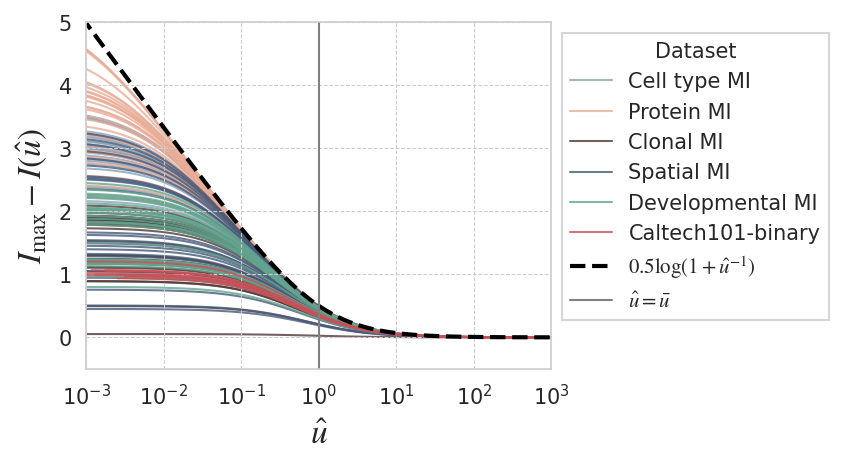

N curves:  10


In [7]:
def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

# plotting setup
fig, ax = plt.subplots()

# params
lw, alpha, ms = 0, 1, 0
hue_order = ['PCA', 'SCVI', 'Geneformer']
plot_fits = True
signals = df['signal'].unique().tolist()

# iterate over signals
def fit_and_plot(df):
    n_curves = 0
    for idx, sig in enumerate(signals):
        sub = df[df['signal'] == sig]
        for s in sub['size'].unique():
            part = sub[sub['size'] == s]
            for alg in hue_order:
                dat = part[part['algorithm'] == alg]
                dat = dat.groupby('umis_per_cell')[['umis_per_cell', 'mi_value']].mean()
                x = dat['umis_per_cell']
                y = dat['mi_value']

                if len(y) < 10:
                    continue

                # get params from sc_param_df
                row = sc_param_df[(sc_param_df['metric'] == sig) 
                                  & (sc_param_df['method'] == alg)
                                  & (sc_param_df['size'] == s)]
                if row.empty:
                    continue
                xbar = row['fitted_u_bar'].values[0]
                imax = row['fitted_I_max'].values[0]
                err_xbar = row['u_bar_error'].values[0]
                err_imax = row['I_max_error'].values[0]

                # check error
                if err_xbar and err_imax and err_xbar < xbar and err_imax < imax:
                    n_curves += 1
                    
                    xhat = x / xbar
                    ax.plot(
                        xhat,
                        imax - y,
                        color=pretty_palette[idx],
                        marker='o',
                        alpha=alpha,
                        markersize=ms,
                        # label=sig,
                        lw=lw
                    )

                    # plot fit
                    xs = np.logspace(-4, 3.5, 100)
                    A = 1/xbar
                    B = A*(2**(2*imax))
                    ys = info_scaling(xs, A, B)
                    if plot_fits:
                        ax.plot(xs/xbar, imax - ys, color=pretty_palette[idx], linestyle='-',
                            alpha=0.8, lw=1, zorder=0.5, label=sig)
                else:
                    # which params are unconstrained?
                    print(f"Unconstrained fit for {sig}, {alg}, size {s}: err_xbar={err_xbar}, err_imax={err_imax}, xbar={xbar}, imax={imax}")
    print("N curves: ", n_curves)

fit_and_plot(df)

n_curves = 0
for im_idx, imdf in enumerate([gaussian_df, res_df]):

    for i, x in enumerate(classes[:-1]):
        # prepare data
        x_name = ['Scale', 'Factor'][im_idx]
        x_data = (1 / (imdf[imdf['Class label'] == x][x_name]))
        y_data = imdf[imdf['Class label'] == x]['MI']

        # create model and parameters
        model = Model(info_scaling)
        params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
        params['A'].min = 0  # set bounds
        params['B'].min = 0

        # fit model
        result = model.fit(y_data, params, x=x_data)
        if result.params['A'].stderr is not None and result.params['B'].stderr is not None:

            if result.params['A'].stderr < result.params['A'].value and result.params['B'].stderr < result.params['B'].value:
                
                n_curves += 1

                x_bar = 1/result.params['A'].value

                x_hat = x_data / x_bar

                I_max = 0.5 * np.log2(result.params['B'].value/result.params['A'].value)

                ax.plot(x_data / x_bar, I_max-y_data, color=pretty_palette[-1], marker='o',
                        alpha=alpha, markersize=ms, lw=lw)

                # plot fit
                xs = np.logspace(-4, 3.5, 100)
                A = 1/x_bar
                B = A*(2**(2*I_max))
                ys = info_scaling(xs, A, B)
                if plot_fits:
                    ax.plot(xs/x_bar, I_max - ys, color=pretty_palette[-1], linestyle='-',
                        alpha=0.8, lw=1, zorder=2, label='Caltech101-binary',)



xs = np.logspace(-4, 3.5, 100)
ys = 0.5*np.log2(1 + 1/xs)
ax.plot(xs, ys, color='black', linestyle='--', alpha=1, lw=2,
         label=r'$0.5 \log (1 + \hat{u}^{-1})$')
ax.plot([1, 1], [-1, 5.5], color='grey', linestyle='-', alpha=1, label=r'$\hat{u} = \bar{u}$', lw=1)


ax.set_xscale('log')
ax.set_ylabel(r'$I_{\max} - I(\hat{u})$',fontsize=16)
ax.set_xlabel(r'$\hat{u}$', fontsize=16)
ax.set_ylim(-0.5, 5)
ax.set_xlim(1e-3, 1e3)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1., 1.), title='Dataset')
plt.show()

print('N curves: ', n_curves)

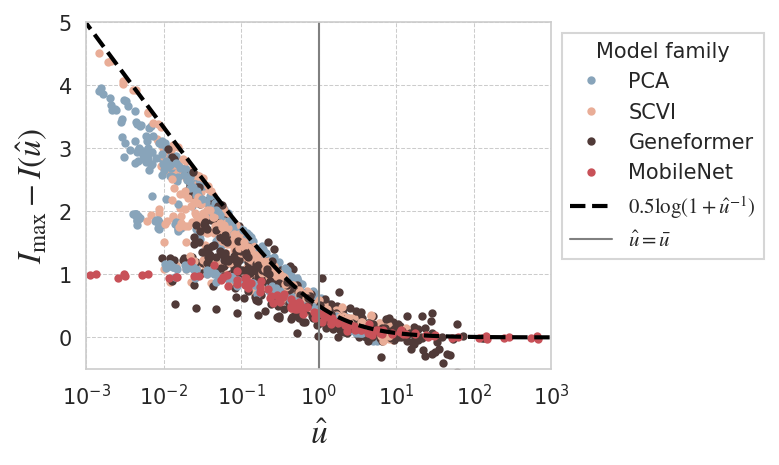

In [8]:
def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

# plotting setup
fig, ax = plt.subplots()

# params
lw, alpha, ms = 0, 1, 3
hue_order = ['PCA', 'SCVI', 'Geneformer']
plot_fits = False
signals = df['signal'].unique().tolist()

# iterate over signals
def fit_and_plot(df):
    for idx, sig in enumerate(signals):
        sub = df[df['signal'] == sig]
        for s in sub['size'].unique():
            part = sub[sub['size'] == s]
            for alg_idx, alg in enumerate(hue_order):
                dat = part[part['algorithm'] == alg]
                dat = dat.groupby('umis_per_cell')[['umis_per_cell', 'mi_value']].mean()
                x = dat['umis_per_cell']
                y = dat['mi_value']

                if len(y) < 10:
                    continue

                # get params from sc_param_df
                row = sc_param_df[(sc_param_df['metric'] == sig) 
                                  & (sc_param_df['method'] == alg)
                                  & (sc_param_df['size'] == s)]
                if row.empty:
                    continue
                xbar = row['fitted_u_bar'].values[0]
                imax = row['fitted_I_max'].values[0]
                err_xbar = row['u_bar_error'].values[0]
                err_imax = row['I_max_error'].values[0]

                # check error
                if err_xbar and err_imax and err_xbar < xbar and err_imax < imax:
                    xhat = x / xbar
                    ax.plot(
                        xhat,
                        imax - y,
                        color=pretty_palette[alg_idx],
                        marker='o',
                        alpha=alpha,
                        markersize=ms,
                        label=alg,
                        lw=lw
                    )

                    # plot fit
                    xs = np.logspace(-4, 3.5, 100)
                    A = 1/xbar
                    B = A*(2**(2*imax))
                    ys = info_scaling(xs, A, B)
                    if plot_fits:
                        ax.plot(xs/xbar, imax - ys, color=pretty_palette[alg_idx], linestyle='--',
                            alpha=0.5, lw=0.5, zorder=0.5, )

fit_and_plot(df)


for im_idx, imdf in enumerate([gaussian_df, res_df]):

    for i, x in enumerate(classes[:-1]):
        # prepare data
        x_name = ['Scale', 'Factor'][im_idx]
        x_data = (1 / (imdf[imdf['Class label'] == x][x_name]))
        y_data = imdf[imdf['Class label'] == x]['MI']

        # create model and parameters
        model = Model(info_scaling)
        params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
        params['A'].min = 0  # set bounds
        params['B'].min = 0

        # fit model
        result = model.fit(y_data, params, x=x_data)
        if result.params['A'].stderr is not None and result.params['B'].stderr is not None:

            if result.params['A'].stderr < result.params['A'].value and result.params['B'].stderr < result.params['B'].value:
                

                x_bar = 1/result.params['A'].value

                x_hat = x_data / x_bar

                I_max = 0.5 * np.log2(result.params['B'].value/result.params['A'].value)

                ax.plot(x_data / x_bar, I_max-y_data, color=pretty_palette[-1], marker='o',
                        alpha=alpha, markersize=ms, label='MobileNet', lw=lw)

                # plot fit
                xs = np.logspace(-4, 3.5, 100)
                A = 1/x_bar
                B = A*(2**(2*I_max))
                ys = info_scaling(xs, A, B)
                if plot_fits:
                    ax.plot(xs/x_bar, I_max - ys, color=pretty_palette[-1], linestyle='--',
                        alpha=0.5, lw=0.5, zorder=2, )



xs = np.logspace(-4, 3.5, 100)
ys = 0.5*np.log2(1 + 1/xs)
ax.plot(xs, ys, color='black', linestyle='--', alpha=1, lw=2,
         label=r'$0.5 \log (1 + \hat{u}^{-1})$')
ax.plot([1, 1], [-1, 5.5], color='grey', linestyle='-', alpha=1, label=r'$\hat{u} = \bar{u}$', lw=1)


ax.set_xscale('log')
ax.set_ylabel(r'$I_{\max} - I(\hat{u})$',fontsize=16)
ax.set_xlabel(r'$\hat{u}$', fontsize=16)
ax.set_ylim(-0.5, 5)
ax.set_xlim(1e-3, 1e3)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1., 1.), title='Model family')
plt.show()

plotting pre-computed data... go!


fitting and plotting for Caltech101-binary...
fitting and plotting for Caltech101-binary...


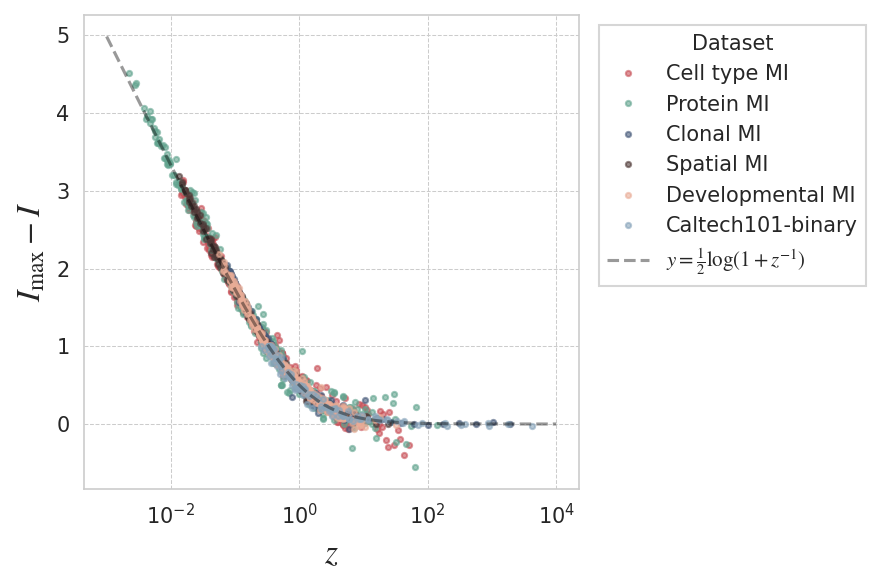

In [42]:
pretty_palette = ["#C85158",
                    "#62A48F",
                    "#475A7A",
                    "#503A38",
                    "#E9AD97",
                    "#88A4BA",]

def plot_points(ax, x, y, color, label):
    ax.plot(x, y, color=color, marker='o', alpha=0.6, ms=2.5, label=label, lw=0)

def plot_fit(ax, x, y, color):
    ax.plot(x, y, color=color, linestyle='--', alpha=0.5, lw=0.75, zorder=0.5)

def transform_to_z(x, xbar, imax):
    A = 2**(-2*imax)
    z = ((x/xbar)+A)/(1-A)
    return z

def plot_precomputed(ax, df, param_df, palette, plot_fits=False):
    """plots data that has pre-calculated fit parameters."""
    print('plotting pre-computed data... go!')
    hue_order = ['PCA', 'SCVI', 'Geneformer']

    # loop through all our datasets
    for idx, sig in enumerate(df['signal'].unique()):
        for size in df['size'].unique():
            for alg in hue_order:
                # grab the right chunk of data
                data = df[(df['signal'] == sig) & (df['size'] == size) & (df['algorithm'] == alg)]
                if len(data) < 10: continue

                avg_data = data.groupby('umis_per_cell').mi_value.mean()
                x, y = avg_data.index, avg_data.values

                # find the magic parameters!
                p = param_df[(param_df['metric'] == sig) & (param_df['method'] == alg) & (param_df['size'] == size)]
                if p.empty: continue
                
                xbar, imax = p['fitted_u_bar'].values[0], p['fitted_I_max'].values[0]
                xbar_err, imax_err = p['u_bar_error'].values[0], p['I_max_error'].values[0]

                # skip if errors are wonky
                if not (xbar_err < xbar and imax_err < imax): continue

                # normalize and plot!
                z = transform_to_z(x, xbar, imax)

                plot_points(ax, z, imax-y, palette[idx], sig)

                # if plot_fits:
                #     xs = np.logspace(-4, 3.5, 100)
                #     a, b = 1 / xbar, (1 / xbar) * (2**(2 * imax))
                #     ys = info_scaling(xs, a, b)
                #     plot_fit(ax, xs / xbar, ys / imax, palette[idx])

def fit_and_plot(ax, df, x_col, color, label, plot_fits=False):
    """fits the model on the fly and plots the results."""
    print(f'fitting and plotting for {label}...')

    for class_label in df['Class label'].unique()[:-1]:
        data = df[df['Class label'] == class_label]
        x_data, y_data = 1 / data[x_col], data['MI']

        # set up and run the model fit
        model = Model(info_scaling)
        params = model.make_params(a=1e-2, b=1e-2)
        params['A'].min = 0
        params['B'].min = 0
        result = model.fit(y_data, params, x=x_data)
        
        # check if the fit is reasonable
        a, b = result.params['A'], result.params['B']
        if a.stderr is not None and b.stderr is not None and a.stderr < a.value and b.stderr < b.value:
            x_bar = 1 / a.value
            i_max = 0.5 * np.log2(b.value / a.value)

            # normalize and plot!
            z = transform_to_z(x_data, x_bar, i_max)
            plot_points(ax, z, (i_max - y_data) / i_max, color, label)
            # and the fit line too
            # if plot_fits:
            #     xs = np.logspace(-4, 3.5, 100)
            #     fit_a, fit_b = 1/x_bar, (1/x_bar) * (2**(2*i_max))
            #     ys = info_scaling(xs, fit_a, fit_b)
            #     # plot_fit(ax, xs/x_bar, ys/i_max, color)


# plotting setup
fig, ax = plt.subplots(figsize=(6, 4))
show_fits = False # set to true to see the fit lines!

# run the plotting functions
plot_precomputed(ax, df, sc_param_df, pretty_palette, show_fits)
fit_and_plot(ax, gaussian_df, 'Scale', pretty_palette[-1], 'Caltech101-binary', show_fits)
fit_and_plot(ax, res_df, 'Factor', pretty_palette[-1], 'Caltech101-binary', show_fits)

# theory curve
xs = np.logspace(-3, 4, 100)
ax.plot(xs, np.log2((1+xs)/xs)/2, color='black', linestyle='--', alpha=0.4, lw=1.5,
         label=r'$y = \frac{1}{2}\log(1 + z^{-1})$',zorder=10)

# make it pretty!
ax.set_xscale('log')
ax.set_ylabel(r'$I_{\max} - I$', fontsize=16) # new label!
ax.set_xlabel(r'$z$', fontsize=16)

# handle the legend so we don't have a million labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left',
           bbox_to_anchor=(1.02, 1.), title='Dataset')

fig.tight_layout()
plt.show()